* Махорин Павел Андреевич
* Имя в kaggle: Pavel Makhorin

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.cluster import KMeans

from sklearn.metrics import r2_score as r2, mean_squared_error as mse

import os
from datetime import datetime

pd.options.display.min_rows = 1000

import warnings
warnings.filterwarnings('ignore')

### Загрузка данных train и test

In [289]:
train_df = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/train.csv')
test_df = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/test.csv')

In [290]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Оптимизация размера памяти, занимаемой данными

Оптимизация памяти в данном случае нужна для ускорения расчета различных моделей (особенно с применением GridSearchCV).

In [291]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [292]:
def memory_compression(df):
    original_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        
        if df[col].dtype != object:
            col_min = df[col].min()
            col_max = df[col].max()

            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    reduced_mem = df.memory_usage().sum()/1024**2
    
    print(f'Изначальный размер занимаемой памяти равен {round(original_mem,2)} мб.')
    print(f'Итоговый размер занимаемой памяти равен {round(reduced_mem,2)} мб.')
    


In [293]:
# Понижение типов данных возожно GridSearch считал быстрее
memory_compression(train_df)
memory_compression(test_df)

Изначальный размер занимаемой памяти равен 1.53 мб.
Итоговый размер занимаемой памяти равен 0.49 мб.
Изначальный размер занимаемой памяти равен 0.72 мб.
Итоговый размер занимаемой памяти равен 0.21 мб.


In [294]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### Приведение типов

In [295]:
train_df['Id'] = train_df['Id'].astype('str')
train_df['DistrictId'] = train_df['DistrictId'].astype('str')
test_df['Id'] = test_df['Id'].astype('str')
test_df['DistrictId'] = test_df['DistrictId'].astype('str')

### Гистограмма искомого признака (price)

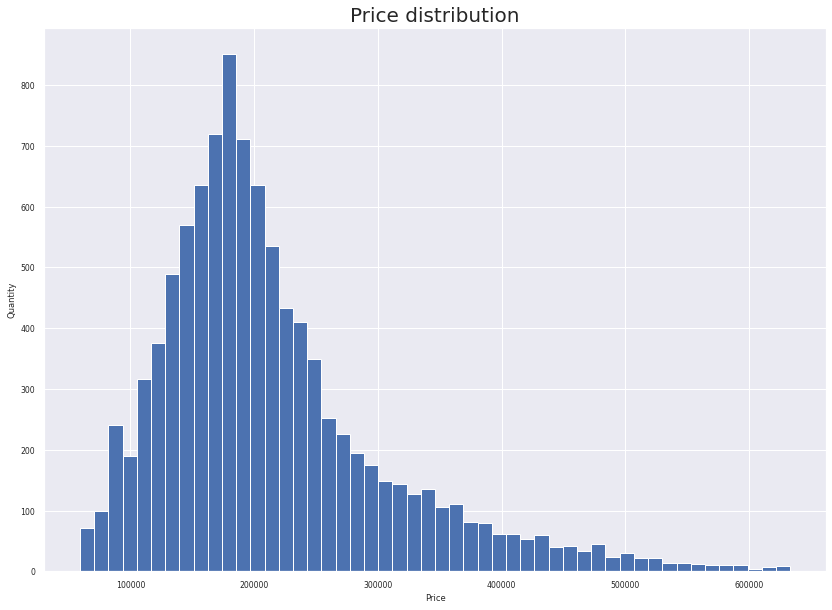

In [296]:
plt.figure(figsize=(14,10))
train_df['Price'].hist(bins=50)
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.title('Price distribution', fontsize=20)
plt.show()

### Строим гистрограммы для всех числовых признаков

Анализируем признаки на наличие выбросов

In [297]:
numeric_cols = ['int16', 'float16', 'int8', 'int32', 'float32']
train_numeric = train_df.select_dtypes(include = numeric_cols)
train_numeric.drop('Price', axis='columns', inplace=True)

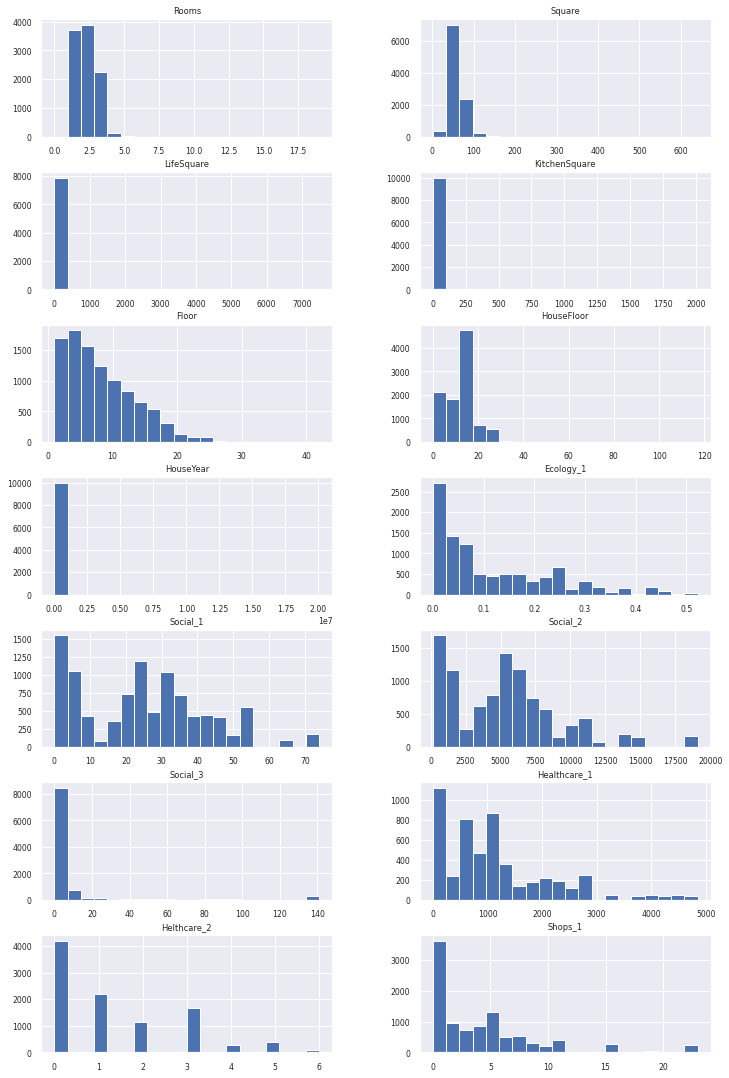

In [298]:
fig, axes = plt.subplots(nrows=7,ncols=2)
for col, axis in zip(train_numeric.columns, axes.flatten()):
    train_numeric.hist(column = col, bins=20, ax=axis)
fig.set_size_inches(12, 19)

In [299]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### Определеляем признаки с пропущенными значениями

In [300]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

### Создание класса для предобработки данных

In [301]:
class DataPreprocessing:
    def __init__(self):
        self.square_to_life_square = None
        self.lifesquare_to_square_ratio = None
        self.life_square_to_replace = None
        self.median_room_size = None
        self.indexes_rooms = None
        self.kitchen_lifesquare_ratio = None
        self.housefloor_by_district = None
        self.housefloor_by_district_med = None
        self.mean_kitchen_square = None
        self.current_year = None
        self.houseyear_by_district = None
        self.house_year_mean = None
        
        
    def fit(self, X):
        self.square_to_life_square = X.loc[~X['LifeSquare'].isna(), 'LifeSquare'] /\
                                     X.loc[~X['LifeSquare'].isna(), 'Square']
        self.lifesquare_to_square_ratio = (self.square_to_life_square < 1).median()
        
        
        self.indexes_rooms = list(X['Rooms'].nlargest(20).index.append(X['Rooms'].nsmallest(20).index))
        self.median_room_size = (X.loc[~X.index.isin(self.indexes_rooms), 'LifeSquare'] /\
                                 X.loc[~X.index.isin(self.indexes_rooms), 'Rooms']).median()
        
        self.kitchen_square_to_replace = (X['KitchenSquare'] < 3.5) |\
                                         (X['KitchenSquare'] >= X['LifeSquare']) |\
                                         (X['KitchenSquare'] <= X['KitchenSquare'].quantile(0.975))
                                                                                      
        
        self.kitchen_lifesquare_ratio = (X.loc[~self.kitchen_square_to_replace, 'KitchenSquare'] /\
                                         X.loc[~self.kitchen_square_to_replace, 'LifeSquare']).median()
        
        self.housefloor_by_district = X.loc[X['HouseFloor'] < X['Floor']]\
                         .groupby(['DistrictId'], as_index=False).agg({'HouseFloor': 'median'})
        self.housefloor_by_district.rename(columns={'HouseFloor':'HouseFloorByDistrict'}, inplace=True)
        self.housefloor_by_district_med = self.housefloor_by_district['HouseFloorByDistrict'].median()
        self.current_year = datetime.today().year
        self.houseyear_by_district = round(X.loc[(X['HouseYear'] < self.current_year) | \
                                                 (X['HouseYear'] > 1800)].\
                              groupby(['DistrictId'], as_index=False).agg({'HouseYear': 'median'}))
        self.houseyear_by_district.rename(columns={'HouseYear':'HouseYearByDistrict'}, inplace=True)
        self.house_year_mean = X['HouseYear'].mean()
        
        
        
    def transform(self, X, y=False):
        
        # Обработка признака Square
        """Удаляем все строки, где LifeSquare больше Square в 1,2 раза. Оставляем зазор в 0,2 для того
           чтобы сохранить данные в этих наблюдениях"""
        self.square_to_life_square2 = X.loc[~X['LifeSquare'].isna(), 'LifeSquare'] /\
                                         X.loc[~X['LifeSquare'].isna(), 'Square']
        if not y:
            X = X.drop(self.square_to_life_square2.loc[self.square_to_life_square2 > 1.2].index)
        
        """Меняем местами Square и LifeSquare там, где Square меньше LifeSquare"""
        X['temp'] = X['Square']
        X['SquareOutlier'] = 0
        X.loc[X['Square'] < X['LifeSquare'], 'temp'] = X.loc[X['Square'] < X['LifeSquare'], 'Square']
        X.loc[X['Square'] < X['LifeSquare'], 'SquareOutlier'] = 1
        X.loc[X['SquareOutlier']==1, 'Square'] = X.loc[X['SquareOutlier']==1, 'LifeSquare']
        X.loc[X['SquareOutlier']==1, 'LifeSquare'] = X.loc[X['SquareOutlier']==1, 'temp']
        del X['temp']

            

        """Удаляем все строки, где значение Square меньше 10 и удалим еще 10 строк с наибольшим значением
           Square"""
        if not y:
            X = X.drop(X.loc[X['Square']<10].index)
            X = X.drop(X['Square'].nlargest(10).index)
    
        
        # Обработка признака "LifeSquare"
        X['LifeSquareOutlier'] = 0
        X.loc[X['LifeSquare'].isna(), 'LifeSquareOutlier'] = 1
        X.loc[X['LifeSquare']<15, 'LifeSquareOutlier'] = 1
        
        """Заменяем значения LifeSquare меньше 15 на медиану отношения LifeSquare к Square
           умноженную на Square"""
        X.loc[X['LifeSquare']<15, 'LifeSquare'] = X.loc[X['LifeSquare']<15, 'Square']\
        * self.lifesquare_to_square_ratio
        
        """Заменяем пустые значения LifeSquare на медиану отношения LifeSquare к Square
           умноженную на Square"""
        X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = X.loc[X['LifeSquare'].isna(), 'Square'] \
                                                      * self.lifesquare_to_square_ratio
        
        
        # Обработка признака "Rooms"
        self.rooms_condition = list(X['Rooms'].nlargest(20).index.append(X['Rooms'].nsmallest(20).index))
        X['RoomsOutlier'] = 0
        X.loc[self.rooms_condition, 'RoomsOutlier'] = 1
        """Заменяем 20 наибольших и 20 наименьших значений признака Rooms на LifeSquare/
           медианный размер комнаты"""
        X.loc[self.rooms_condition, 'Rooms'] = round(X.loc[self.rooms_condition, 'LifeSquare'] /\
                                               self.median_room_size)
        
        
        
        # Обработка признака "KitchenSquare"
        self.kitchen_condition = (X['KitchenSquare'] < 3.5) |\
                                 (X['KitchenSquare'] >= X['LifeSquare']) |\
                                 (X['KitchenSquare'] <= X['KitchenSquare'].quantile(0.975))
                                                                                       
        """Составляем список индексов наблюдений, в которых нужно заменить площадь кухни - площадь кухни менее
           3,5 метров, площадь кухни больше жилой площади, 100 наибольших значений площади кухни. По этим
           индексам заменяем значения среднее отношение площади кухни к жилой площади умноженное на жилую
           площадь."""
        X['KitchenSquareOutlier'] = 0
        X.loc[self.kitchen_condition, 'KitchenSquareOutlier'] = 1
        X.loc[self.kitchen_condition, 'KitchenSquare'] = X.loc[self.kitchen_condition, \
                                                                'LifeSquare'] * self.kitchen_lifesquare_ratio
        
        
        # Обработка признака "HouseFloor"
        """Расчитываем средний этаж дома по району. В случае если этажность дома меньше этажа квартиры, и
           то заменяем этаж квартиры на средний"""
        X = X.merge(self.housefloor_by_district, on='DistrictId', how='left')
        
        """Заполняем пустые значения, которые погут возникнуть в тестовых данных"""
        X['HouseFloorByDistrict'].fillna(self.housefloor_by_district_med, inplace=True)
        X.loc[((X['Floor'] < X['HouseFloorByDistrict'])&(X['HouseFloor'] < X['Floor'])), 'HouseFloor'] = \
        X.loc[((X['Floor'] < X['HouseFloorByDistrict'])&(X['HouseFloor'] < X['Floor'])),\
                                                                                  'HouseFloorByDistrict']
        
        """Если остались дома, в которых этаж квартиры больше этажности дома, то делаем этажность дома
           равной этажу квартиры"""
        X.loc[X['HouseFloor'] < X['Floor'], 'HouseFloor'] =\
        X.loc[X['HouseFloor'] < X['Floor'], 'Floor']
        
        """Пересчитываем средний этаж по району, с учетом исправленных ранее данных"""
        self.housefloor_by_district = X.groupby(['DistrictId'], as_index=False).agg({'HouseFloor': 'median'})
        self.housefloor_by_district.rename(columns={'HouseFloor': 'HouseFloorByDistrict'}, inplace=True)
        del X['HouseFloorByDistrict']
        X = X.merge(self.housefloor_by_district, on='DistrictId', how='left')
        
        
        
        # Обработка признака "HouseYear"
        """Расчитываем средний год по району, при этом не учитываем значения годов постройки менее 1800
           и выше текущего значения года. Заменяем для каждого наблюдения, в котором год постройки дома
           меньше 1800 и больше текущего года на сренднее значение по району"""
        X = X.merge(self.houseyear_by_district, on='DistrictId', how='left')
        X.loc[(X['HouseYear'] > self.current_year) | (X['HouseYear'] < 1800), 'HouseYear'] =\
        X.loc[(X['HouseYear'] > self.current_year) | (X['HouseYear'] < 1800), 'HouseYearByDistrict']
        X['HouseYear'].fillna(self.house_year_mean, inplace=True)
        X['HouseYearByDistrict'].fillna(self.house_year_mean, inplace=True)
        
        return X

In [302]:
prep = DataPreprocessing()

In [303]:
prep.fit(train_df)

In [304]:
train_df = prep.transform(train_df)

In [305]:
test_df = prep.transform(test_df, y=True)

### Создание класса для генерации новых признаков

In [306]:
class FeatureGenerator:
    
    def __init__(self):
        self.price_per_flat_by_district = None
        self.price_per_flat_by_district_med = None
        self.ecology1_by_district = None
        self.ecology1_by_district_med = None
        self.helthcare2_by_district = None
        self.helthcare2_by_district_med = None
        self.shops_1_by_district = None
        self.shops_1_by_district_med = None
        self.district_size = None
        self.district_size_med = None
        self.binary_numbers = None
        
    
    
    def fit(self, X, y=None):
        
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            self.price_per_flat_by_district = df.groupby(['DistrictId', 'Rooms'],\
                                                        as_index=False).agg({'Price': 'median'})
            self.price_per_flat_by_district.rename(columns={'Price': 'PricePerFlatByDistrict'}, inplace=True)
            
            self.price_per_flat_by_district_med =\
            self.price_per_flat_by_district['PricePerFlatByDistrict'].median()
        
        self.ecology1_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Ecology_1': 'mean'})
        self.ecology1_by_district.rename(columns={'Ecology_1': 'Ecology1ByDistrict'}, inplace=True)
        self.ecology1_by_district_med = self.ecology1_by_district['Ecology1ByDistrict'].median()
        
        self.helthcare2_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Helthcare_2': 'mean'})
        self.helthcare2_by_district.rename(columns={'Helthcare_2': 'Healthcare2ByDistrict'}, inplace=True)
        self.helthcare2_by_district_med = self.helthcare2_by_district['Healthcare2ByDistrict'].median()
        
        self.shops_1_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Shops_1': 'mean'})
        self.shops_1_by_district.rename(columns={'Shops_1': 'Shops1ByDistrict'}, inplace=True)
        self.shops_1_by_district_med = self.shops_1_by_district['Shops1ByDistrict'].median()
        
        self.district_size = X.groupby(['DistrictId'], as_index=False).agg({'Id': 'count'})
        self.district_size.rename(columns={'Id': 'DistrictSize'}, inplace=True)
        self.district_size_med = self.district_size['DistrictSize'].median()
        
        self.binary_numbers = {'A': 0, 'B': 1}
    
    
    def transform(self, X):
        # Средняя цена квартиры в каждом районе
        """Расчитываем среднюю стоимость квартиры для района и присваем наблюдению расчитанное значение"""
        X = X.merge(self.price_per_flat_by_district, on=['DistrictId', 'Rooms'], how='left')
        X['PricePerFlatByDistrict'].fillna(self.price_per_flat_by_district_med, inplace=True)
        
        
        # Средние показатели Healthcare2 по районам
        X = X.merge(self.helthcare2_by_district, on='DistrictId', how='left')
        X['Healthcare2ByDistrict'].fillna(self.helthcare2_by_district_med, inplace=True)
        
         # Средние показатели по экологии по районам
        X = X.merge(self.ecology1_by_district, on='DistrictId', how='left')
        X['Ecology1ByDistrict'].fillna(self.ecology1_by_district_med, inplace=True)

        # Размер района
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['DistrictSize'].fillna(self.district_size_med, inplace=True)

        # Средние показатели связанные с доступностью магазинов по районам
        X = X.merge(self.shops_1_by_district, on='DistrictId', how='left')
        X['Shops1ByDistrict'].fillna(self.shops_1_by_district_med, inplace=True)
        
        
        
        # Средний размер комнаты в квартире
        X['RoomSize'] = X['LifeSquare'] / X['Rooms']
        
        
        # Перевод года постройки в категории
        X = self.year_cat(X)
        
         # Перевод этажей в категории
        X = self.floor_cat(X)
        

        X['Ecology_2'].replace(self.binary_numbers, inplace=True)
        X['Ecology_3'].replace(self.binary_numbers, inplace=True)
        X['Shops_2'].replace(self.binary_numbers, inplace=True)
        
        
        # Отметка квартиры, которая находится на первом или последнем этаже дома
        X['FirstLastFloor'] = 0
        X.loc[(X['Floor'] == 1) | (X['Floor'] == X['HouseFloor']), 'FirstLastFloor'] = 1
       
        return X
        
        
    def floor_cat(self, X):
        bins = [0, 3, 5, 10, 20, 40, 200]
        X['FloorCat'] = pd.cut(X['Floor'], bins = bins, labels=False)
        X['FloorCat'].fillna(-1, inplace=True) 
        return X
    
    
    def year_cat(self, X):
        bins = [1900, 1940, 1960, 1980, 2000, 2010, 2040]
        X['YearCat'] = pd.cut(train_df['HouseYear'], bins=bins, labels=False)
        X['YearCat'].fillna(-1, inplace=True) 
        return X

In [307]:
feat = FeatureGenerator()

In [308]:
feat.fit(train_df.drop(columns='Price'), train_df['Price'])

In [309]:
train_df = feat.transform(train_df)

In [310]:
test_df = feat.transform(test_df)

In [311]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9973
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      9974 non-null   object 
 1   DistrictId              9974 non-null   object 
 2   Rooms                   9974 non-null   float32
 3   Square                  9974 non-null   float32
 4   LifeSquare              9974 non-null   float32
 5   KitchenSquare           9974 non-null   float32
 6   Floor                   9974 non-null   int8   
 7   HouseFloor              9974 non-null   float32
 8   HouseYear               9974 non-null   float64
 9   Ecology_1               9974 non-null   float32
 10  Ecology_2               9974 non-null   int64  
 11  Ecology_3               9974 non-null   int64  
 12  Social_1                9974 non-null   int8   
 13  Social_2                9974 non-null   int16  
 14  Social_3                9974 non-null   

In [312]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      5000 non-null   object 
 1   DistrictId              5000 non-null   object 
 2   Rooms                   5000 non-null   float32
 3   Square                  5000 non-null   float32
 4   LifeSquare              5000 non-null   float32
 5   KitchenSquare           5000 non-null   float32
 6   Floor                   5000 non-null   int8   
 7   HouseFloor              5000 non-null   float32
 8   HouseYear               5000 non-null   float64
 9   Ecology_1               5000 non-null   float32
 10  Ecology_2               5000 non-null   int64  
 11  Ecology_3               5000 non-null   int64  
 12  Social_1                5000 non-null   int8   
 13  Social_2                5000 non-null   int16  
 14  Social_3                5000 non-null   

In [313]:
memory_compression(test_df)

Изначальный размер занимаемой памяти равен 0.93 мб.
Итоговый размер занимаемой памяти равен 0.65 мб.


### Заполнение пропусков для Healthcare_1

In [314]:
def evaluate_preds(true_values, pred_values, max_x = 700000, max_y = 700000, save=False):
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, max_x], [0, max_y], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    

    plt.show()

#### Создание модели для заполнения данных

In [315]:
train_hc = train_df.loc[~train_df['Healthcare_1'].isna()]
test_hc = train_df.loc[train_df['Healthcare_1'].isna()]

train_hc = train_hc.reset_index()
del train_hc['index']

hc_features = train_hc.select_dtypes(include=['int8', 'int16', 'int64', 'float64', 'float32']).\
columns.to_list()
hc_features_to_train = hc_features.copy()

hc_features_to_train.remove('Healthcare_1')
hc_features_to_train.remove('Price')

X = train_hc[hc_features_to_train]
y = train_hc['Healthcare_1']

X_train_hc, X_test_hc, y_train_hc, y_test_hc = train_test_split(X, y, test_size=0.33, random_state=42)

gb_hc_model = GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10, random_state=42,\
                                        n_estimators=100)
gb_hc_model.fit(X_train_hc, y_train_hc)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#### Оценка полученной модели

R2:	0.999
RMSE:	26.23
MSE:	687.992


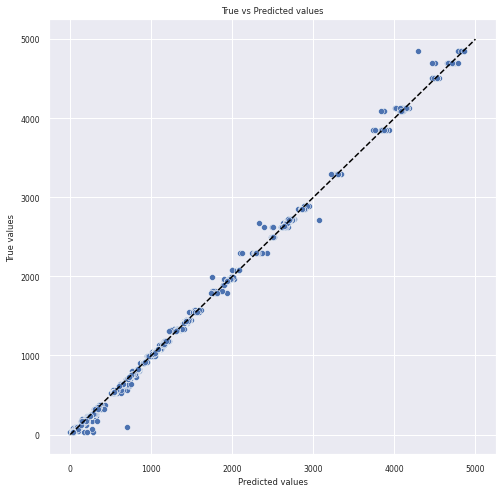

In [316]:
# Оценим модель
y_train_hc_gb_pred = gb_hc_model.predict(X_train_hc)
evaluate_preds(y_train_hc, y_train_hc_gb_pred, max_x=5000, max_y=5000)

R2:	0.996
RMSE:	66.46
MSE:	4416.928


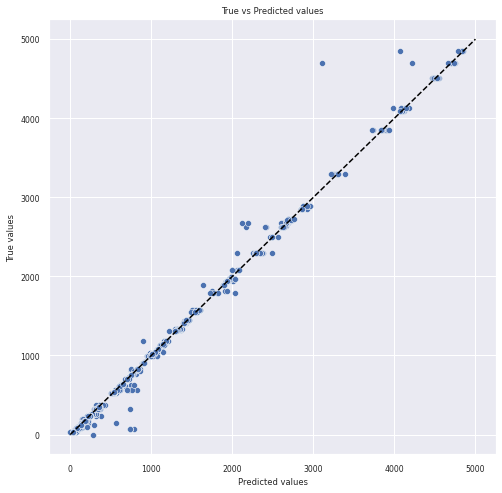

In [317]:
# Оценим как модель предсказывает целевой признак из тестовой выборки
y_test_hc_gb_preds = gb_hc_model.predict(X_test_hc)
evaluate_preds(y_test_hc, y_test_hc_gb_preds, max_x=5000, max_y=5000)

In [318]:
feature_importances = pd.DataFrame(zip(hc_features, gb_hc_model.feature_importances_),\
                                   columns=('Features', 'Importances'))
feature_importances.sort_values(by='Importances', ascending=False).head(10)

,Features,Importances
11,Social_2,0.196910
12,Social_3,0.160917
7,Ecology_1,0.139875
10,Social_1,0.116534
20,RoomsOutlier,0.090843
23,HouseYearByDistrict,0.068890
13,Healthcare_1,0.052239
25,Healthcare2ByDistrict,0.047386
14,Helthcare_2,0.046603
9,Ecology_3,0.025426


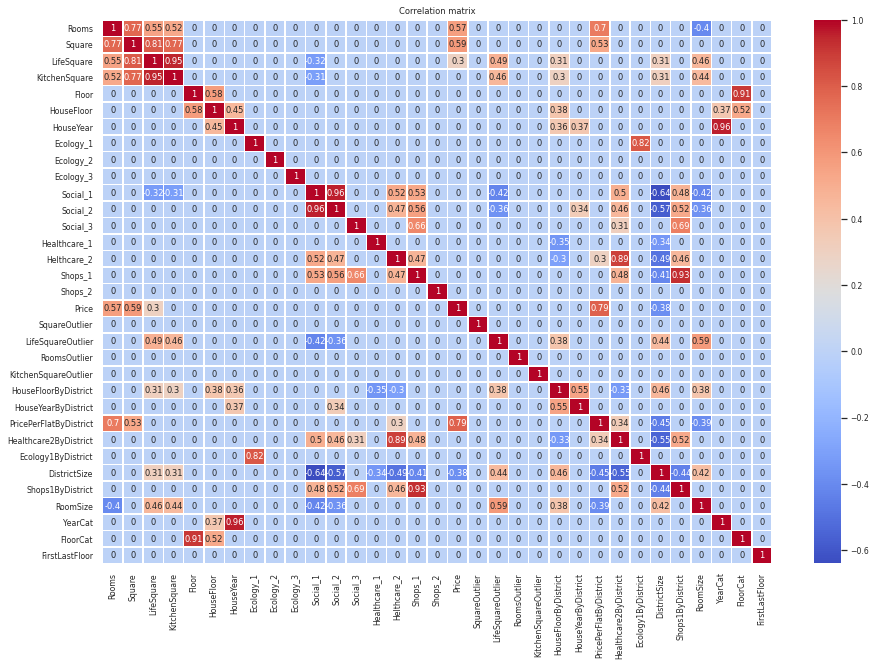

In [319]:
plt.figure(figsize = (15,10))

sns.set(font_scale=0.7)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [320]:
# Заполним значения в тренировочных и тестовых данных
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
gb_hc_model.predict(train_df.loc[train_df['Healthcare_1'].isna(), hc_features_to_train])

test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] =\
gb_hc_model.predict(test_df.loc[test_df['Healthcare_1'].isna(), hc_features_to_train])

### Построение модели кластеризации для создания еще одного признака

In [321]:
scaler = StandardScaler()

In [322]:
train_scaled = pd.DataFrame(scaler.fit_transform(train_df.drop(columns='Price')),\
                            columns=train_df.drop(columns='Price').columns.to_list())

In [323]:
test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns.to_list())

In [324]:
kmeans_feature = KMeans(n_clusters=5, random_state=42)

In [325]:
cluster_features = [ 'PricePerFlatByDistrict',
                     'Square',
                     'RoomSize',
                     'DistrictSize',
                     'HouseYear',
                     'HouseFloor',
                     'HouseYearByDistrict',
                     'Floor',
                     'Healthcare_1',
                     'LifeSquare',
                     'HouseFloorByDistrict']


In [326]:
labels_kmeans = kmeans_feature.fit_predict(train_scaled[cluster_features])
labels_kmeans_test = kmeans_feature.predict(test_scaled[cluster_features])

In [327]:
kmeans_dummies = pd.get_dummies(labels_kmeans, drop_first=True, prefix='kmeans5')
kmeans_dummies_test = pd.get_dummies(labels_kmeans_test, drop_first=True, prefix='kmeans5')

In [328]:
train_scaled = pd.concat([train_scaled, kmeans_dummies], axis=1)
test_scaled = pd.concat([test_scaled, kmeans_dummies_test], axis=1)

### Построение модели для прогноза целевого признака

In [329]:
"""Признаки отобрал по принципу 17-и самых значимых по итогам формирования модели. Изначально формировал
   модель на всех имеющихся признаках"""
features = [ 'PricePerFlatByDistrict',
             'Square',
             'RoomSize',
             'HouseYear',
             'kmeans5_4',
             'DistrictSize',
             'HouseYearByDistrict',
             'kmeans5_2',
             'Social_3',
             'HouseFloor',
             'Healthcare_1',
             'Social_1',
             'Ecology_1',
             'Floor',
             'Social_2',
             'KitchenSquare',
             'Rooms']
X = train_scaled[features]
y = train_df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [330]:
gb_model = GradientBoostingRegressor()

R2:	0.839
RMSE:	37216.264
MSE:	1385050329.957


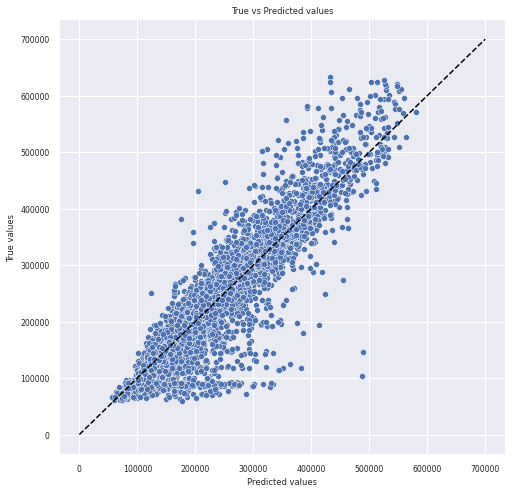

In [331]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     n_estimators=100,
                                     min_samples_leaf=50,
                                     random_state=42)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.751
RMSE:	45851.525
MSE:	2102362299.165


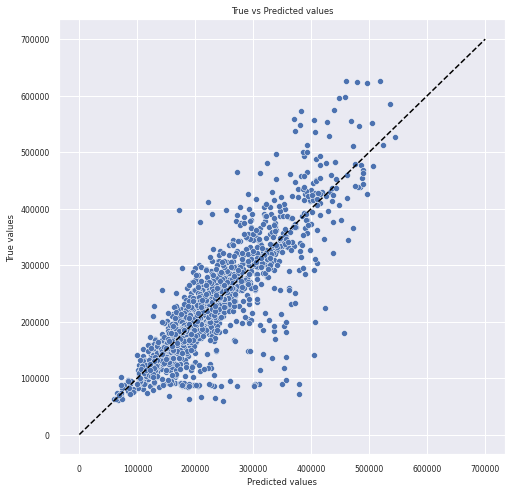

In [332]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [333]:
feature_importances = pd.DataFrame(zip(features, gb_model.feature_importances_),\
                                   columns=('Feature', 'Importance'))
feature_importances.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,PricePerFlatByDistrict,0.718146
1,Square,0.118439
3,HouseYear,0.023431
2,RoomSize,0.022329
5,DistrictSize,0.019378
8,Social_3,0.014468
9,HouseFloor,0.012395
6,HouseYearByDistrict,0.011361
15,KitchenSquare,0.011133
11,Social_1,0.010323


In [334]:
feature_importances.sort_values(by='Importance', ascending=False)['Feature'].to_list()[:25]

['PricePerFlatByDistrict',
 'Square',
 'HouseYear',
 'RoomSize',
 'DistrictSize',
 'Social_3',
 'HouseFloor',
 'HouseYearByDistrict',
 'KitchenSquare',
 'Social_1',
 'Social_2',
 'Healthcare_1',
 'Ecology_1',
 'Floor',
 'Rooms',
 'kmeans5_4',
 'kmeans5_2']

In [335]:
cv_score = cross_val_score(gb_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.75087388, 0.77083809, 0.75474809, 0.77328866, 0.76835811])

### Прогнозирование на тестовом датасете

In [336]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')

In [337]:
predictions = gb_model.predict(test_scaled[features]) 

In [338]:
submit['Price'] = predictions

In [339]:
submit.to_csv('submit.csv', index=False)